In [2]:
# Imports
import mindspore
import mindspore as ms
from mindspore import nn, context, Tensor, ops
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as vision
import mindspore.nn.probability.distribution as msd
import numpy as np
from mindspore.dataset.transforms import Compose
context.set_context(device_target='CPU')
batch_size = 128

class Encoder(nn.Cell):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Dense(D_in, H)
        self.linear2 = nn.Dense(H, latent_size)
        self.linear3 = nn.Dense(H, latent_size)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = x.reshape(batch_size, -1)
        x = self.linear1(x)
        x = self.relu(x)
        mu = self.linear2(x)
        sigma = self.linear3(x)
        return mu, sigma


class Decoder(nn.Cell):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = nn.Dense(D_in, H)
        self.linear2 = nn.Dense(H, D_out)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        x = self.relu(self.linear1(x))
        return self.sigmoid(self.linear2(x))
class VAE(nn.Cell):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.n = msd.Normal(0.0, 1.0)
    def construct(self, x):
        mu, std = self.encoder(x)
        z = self.sample(mu, std)
        return self.decoder(z), mu, std

    def sample(self, mu, std):
        std = ops.exp(0.5 * std)
        eps = self.n.sample(std.shape)
        z = mu + eps * std
        return z

def kl_loss(shape, mean, std):
    loss = 0.5 * (
                1 + 2 * std - mean ** 2 - ms.ops.Exp()(std)**2).sum()
    return loss

class VAELoss(mindspore.nn.Cell):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.loss_fn = mindspore.nn.BCEWithLogitsLoss()

    def construct(self, x):
        predict, mean, std = self.net(x)
        klloss = kl_loss(predict.shape[0], mean, std)
        loss = ops.binary_cross_entropy(predict, x.reshape(batch_size, -1), reduction='sum')
        return loss - klloss



In [3]:
num_epochs = 100
learning_rate = 0.001
hidden_size = 512
latent_size = 8
input_dim = 28 * 28

transform = C.Compose([
    vision.ToTensor(),
    ])

mnist_dataset = ds.MnistDataset('./mnist/train')
mnist_dataset = mnist_dataset.map(operations=transform, input_columns=["image"])
dataset = mnist_dataset.batch(batch_size, drop_remainder=True)
iterator = dataset.create_dict_iterator()

encoder = Encoder(input_dim, hidden_size, latent_size)
decoder = Decoder(latent_size, hidden_size, input_dim)

vae = VAE(encoder, decoder)
print(vae)
optimizer = nn.Adam(vae.trainable_params(), learning_rate)
loss_fn = VAELoss(vae)
train_net = mindspore.nn.TrainOneStepCell(loss_fn, optimizer)



VAE<
  (encoder): Encoder<
    (linear1): Dense<input_channels=784, output_channels=512, has_bias=True>
    (linear2): Dense<input_channels=512, output_channels=8, has_bias=True>
    (linear3): Dense<input_channels=512, output_channels=8, has_bias=True>
    (relu): ReLU<>
    >
  (decoder): Decoder<
    (linear1): Dense<input_channels=8, output_channels=512, has_bias=True>
    (linear2): Dense<input_channels=512, output_channels=784, has_bias=True>
    (relu): ReLU<>
    (sigmoid): Sigmoid<>
    >
  (n): Normal<mean = 0.0, standard deviation = 1.0>
  >


## 训练


In [3]:
from tqdm import tqdm
train_net.set_train()
for i in range(num_epochs):
    for data in tqdm(iterator):
        loss = train_net(data['image'])
    print('step {}'.format(i), loss)

468it [00:59,  7.89it/s]
1it [00:00,  8.31it/s]

step 0 21139.777


468it [00:57,  8.12it/s]
1it [00:00,  8.29it/s]

step 1 18479.127


468it [00:56,  8.24it/s]
1it [00:00,  8.34it/s]

step 2 17976.555


468it [00:56,  8.25it/s]
1it [00:00,  8.50it/s]

step 3 16463.697


468it [00:56,  8.33it/s]
1it [00:00,  8.43it/s]

step 4 16598.365


468it [00:55,  8.42it/s]
1it [00:00,  8.39it/s]

step 5 16703.762


468it [00:57,  8.17it/s]
1it [00:00,  7.73it/s]

step 6 17050.906


468it [00:57,  8.09it/s]
1it [00:00,  8.07it/s]

step 7 17237.91


468it [00:57,  8.18it/s]
1it [00:00,  8.06it/s]

step 8 16957.148


468it [00:57,  8.13it/s]
1it [00:00,  8.28it/s]

step 9 16324.079


468it [00:57,  8.14it/s]
1it [00:00,  8.41it/s]

step 10 15531.738


468it [00:56,  8.23it/s]
1it [00:00,  7.96it/s]

step 11 16627.248


468it [00:57,  8.15it/s]
1it [00:00,  8.33it/s]

step 12 15655.146


468it [00:57,  8.12it/s]
1it [00:00,  8.17it/s]

step 13 15210.883


468it [00:57,  8.09it/s]
1it [00:00,  8.26it/s]

step 14 15584.605


468it [00:57,  8.17it/s]
1it [00:00,  8.43it/s]

step 15 15676.839


468it [00:57,  8.16it/s]
1it [00:00,  8.19it/s]

step 16 15764.355


468it [00:57,  8.15it/s]
1it [00:00,  8.41it/s]

step 17 16302.912


468it [00:57,  8.15it/s]
1it [00:00,  7.94it/s]

step 18 16035.065


468it [00:57,  8.10it/s]
1it [00:00,  8.25it/s]

step 19 16072.895


468it [00:57,  8.12it/s]
1it [00:00,  8.23it/s]

step 20 15385.777


468it [00:57,  8.10it/s]
1it [00:00,  8.36it/s]

step 21 15624.199


468it [00:57,  8.21it/s]
1it [00:00,  8.26it/s]

step 22 15837.142


468it [00:57,  8.20it/s]
1it [00:00,  8.13it/s]

step 23 16025.439


468it [00:57,  8.20it/s]
1it [00:00,  8.43it/s]

step 24 16451.82


468it [00:56,  8.26it/s]
1it [00:00,  8.34it/s]

step 25 15437.543


468it [00:55,  8.43it/s]
1it [00:00,  8.55it/s]

step 26 15704.213


468it [00:56,  8.23it/s]
1it [00:00,  8.15it/s]

step 27 15501.716


468it [00:57,  8.14it/s]
1it [00:00,  8.24it/s]

step 28 15521.697


468it [00:57,  8.19it/s]
1it [00:00,  8.29it/s]

step 29 15344.453


468it [00:56,  8.25it/s]
1it [00:00,  8.55it/s]

step 30 15118.653


468it [00:56,  8.28it/s]
1it [00:00,  8.05it/s]

step 31 16054.756


468it [00:57,  8.11it/s]
1it [00:00,  7.71it/s]

step 32 15857.48


468it [00:57,  8.11it/s]
1it [00:00,  7.95it/s]

step 33 15254.967


468it [00:57,  8.18it/s]
1it [00:00,  8.32it/s]

step 34 15524.262


468it [00:57,  8.17it/s]
1it [00:00,  8.24it/s]

step 35 15082.41


468it [00:56,  8.22it/s]
1it [00:00,  8.33it/s]

step 36 15628.039


468it [00:56,  8.25it/s]
1it [00:00,  8.21it/s]

step 37 14913.471


468it [00:57,  8.17it/s]
1it [00:00,  8.29it/s]

step 38 14988.932


468it [00:57,  8.07it/s]
1it [00:00,  8.20it/s]

step 39 15113.753


468it [00:57,  8.17it/s]
1it [00:00,  8.57it/s]

step 40 15630.99


468it [00:57,  8.20it/s]
1it [00:00,  8.06it/s]

step 41 14746.941


468it [00:56,  8.25it/s]
1it [00:00,  8.37it/s]

step 42 15142.365


468it [00:56,  8.23it/s]
1it [00:00,  8.31it/s]

step 43 15299.604


468it [00:57,  8.13it/s]
1it [00:00,  8.04it/s]

step 44 14788.829


468it [00:57,  8.12it/s]
1it [00:00,  8.19it/s]

step 45 15128.372


468it [00:56,  8.23it/s]
1it [00:00,  8.33it/s]

step 46 15319.857


468it [00:57,  8.15it/s]
1it [00:00,  8.42it/s]

step 47 15294.01


468it [00:57,  8.17it/s]
1it [00:00,  8.23it/s]

step 48 15616.611


468it [00:56,  8.24it/s]
1it [00:00,  8.28it/s]

step 49 15606.679


468it [00:57,  8.17it/s]
1it [00:00,  8.30it/s]

step 50 15182.599


468it [00:56,  8.22it/s]
1it [00:00,  8.14it/s]

step 51 15293.762


468it [00:57,  8.18it/s]
1it [00:00,  8.18it/s]

step 52 14651.52


468it [00:57,  8.10it/s]
1it [00:00,  8.22it/s]

step 53 15008.318


468it [00:57,  8.18it/s]
1it [00:00,  8.28it/s]

step 54 15707.859


468it [00:57,  8.07it/s]
1it [00:00,  8.10it/s]

step 55 15238.037


468it [00:58,  8.06it/s]
1it [00:00,  7.92it/s]

step 56 15440.179


468it [00:58,  8.06it/s]
1it [00:00,  7.82it/s]

step 57 14996.083


468it [00:57,  8.08it/s]
1it [00:00,  7.52it/s]

step 58 15622.033


468it [00:57,  8.11it/s]
1it [00:00,  8.37it/s]

step 59 14674.699


468it [00:57,  8.17it/s]
1it [00:00,  8.53it/s]

step 60 15531.08


468it [00:57,  8.13it/s]
1it [00:00,  8.29it/s]

step 61 14959.818


468it [00:57,  8.12it/s]
1it [00:00,  8.20it/s]

step 62 15585.835


468it [00:57,  8.08it/s]
1it [00:00,  8.26it/s]

step 63 15628.617


468it [00:57,  8.12it/s]
1it [00:00,  8.38it/s]

step 64 15519.125


468it [00:57,  8.16it/s]
1it [00:00,  8.43it/s]

step 65 15477.625


468it [00:56,  8.23it/s]
1it [00:00,  7.42it/s]

step 66 15516.267


468it [00:57,  8.08it/s]
1it [00:00,  8.11it/s]

step 67 15333.064


468it [00:58,  8.05it/s]
1it [00:00,  7.83it/s]

step 68 15144.322


468it [00:57,  8.14it/s]
1it [00:00,  8.01it/s]

step 69 15173.25


468it [00:57,  8.12it/s]
1it [00:00,  8.21it/s]

step 70 15161.974


468it [00:58,  8.05it/s]
1it [00:00,  8.20it/s]

step 71 14860.379


468it [00:57,  8.09it/s]
1it [00:00,  8.36it/s]

step 72 15672.216


468it [00:57,  8.15it/s]
1it [00:00,  8.34it/s]

step 73 15607.409


468it [00:57,  8.19it/s]
1it [00:00,  8.05it/s]

step 74 15091.247


468it [00:58,  8.07it/s]
1it [00:00,  8.21it/s]

step 75 15713.3545


468it [00:58,  8.04it/s]
1it [00:00,  8.01it/s]

step 76 14599.768


468it [00:58,  8.01it/s]
1it [00:00,  8.29it/s]

step 77 15196.821


468it [00:57,  8.10it/s]
1it [00:00,  8.22it/s]

step 78 14982.45


468it [00:57,  8.11it/s]
1it [00:00,  8.12it/s]

step 79 15815.163


468it [00:58,  8.05it/s]
1it [00:00,  8.21it/s]

step 80 15513.848


468it [00:57,  8.11it/s]
1it [00:00,  8.26it/s]

step 81 15313.48


468it [00:57,  8.09it/s]
1it [00:00,  8.29it/s]

step 82 14689.207


468it [00:57,  8.17it/s]
1it [00:00,  7.89it/s]

step 83 16022.699


468it [00:57,  8.12it/s]
1it [00:00,  8.16it/s]

step 84 15504.187


468it [00:57,  8.13it/s]
1it [00:00,  8.13it/s]

step 85 15724.391


468it [00:57,  8.11it/s]
1it [00:00,  8.16it/s]

step 86 15163.632


468it [00:57,  8.12it/s]
1it [00:00,  8.32it/s]

step 87 15478.204


468it [00:57,  8.14it/s]
1it [00:00,  8.10it/s]

step 88 15251.104


468it [00:58,  8.01it/s]
1it [00:00,  8.16it/s]

step 89 15013.906


468it [00:57,  8.12it/s]
1it [00:00,  8.23it/s]

step 90 14465.478


468it [00:57,  8.12it/s]
1it [00:00,  8.28it/s]

step 91 15663.435


468it [00:58,  8.04it/s]
1it [00:00,  8.33it/s]

step 92 15324.186


468it [00:57,  8.15it/s]
1it [00:00,  8.12it/s]

step 93 15008.029


468it [00:57,  8.10it/s]
1it [00:00,  8.35it/s]

step 94 14841.523


468it [00:57,  8.18it/s]
1it [00:00,  8.33it/s]

step 95 14937.142


468it [00:58,  8.00it/s]
1it [00:00,  7.91it/s]

step 96 14596.439


468it [00:57,  8.13it/s]
1it [00:00,  8.22it/s]

step 97 15326.958


468it [00:57,  8.16it/s]
1it [00:00,  8.30it/s]

step 98 14755.012


468it [00:57,  8.14it/s]

step 99 15764.002


In [8]:
test_dataset = ds.MnistDataset('./mnist/test')
test_dataset = test_dataset.map(operations=transform)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
test_iterator = test_dataset.create_dict_iterator()

## 推理

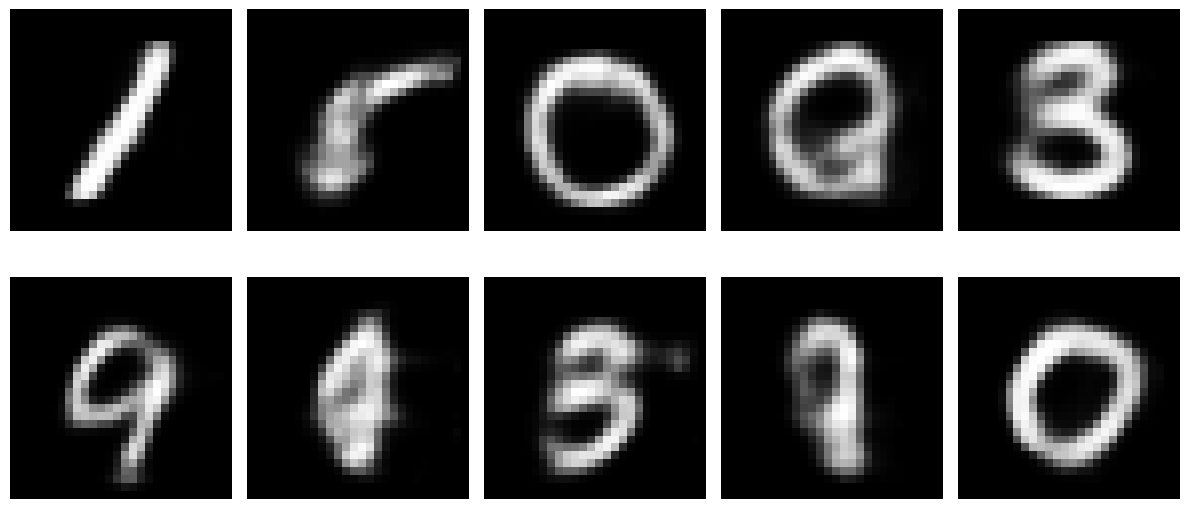

In [9]:
import matplotlib.pyplot as plt

# 加载MNIST数据集
test = vae.decoder(ops.normal((128, 8), mindspore.Tensor(0), mindspore.Tensor(1)))
# 随机选择一些图像
num_images = 10

# 创建一个2x5的子图
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# 可视化图像
for i in range(10):
    image = np.squeeze(test[i].reshape(28, 28).numpy())  # 去除额外的维度
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


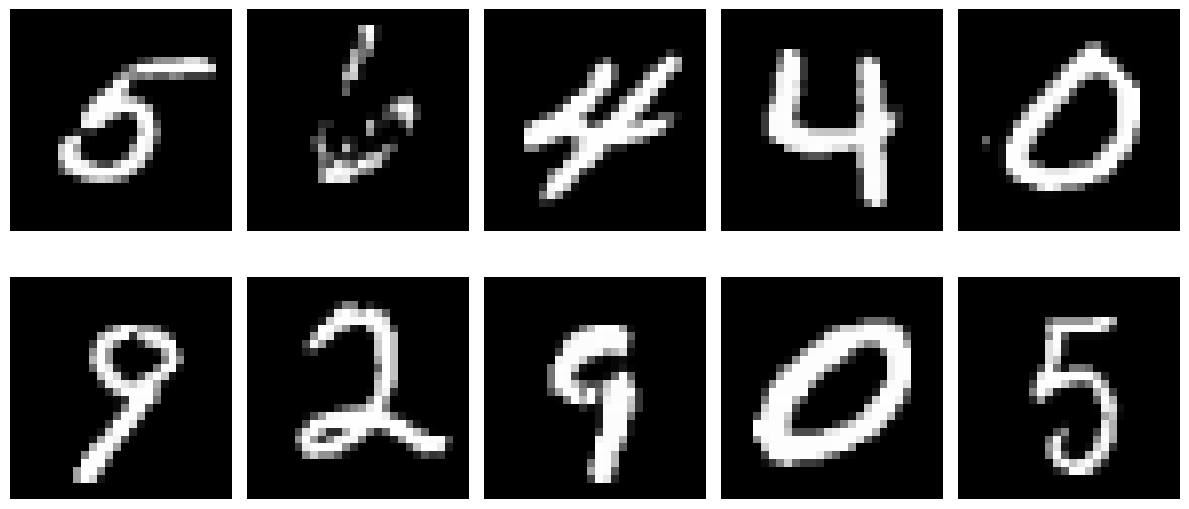

In [10]:

# 加载MNIST数据集
for i in  test_iterator:
    test = i['image']
    break
# 随机选择一些图像
num_images = 10

# 创建一个2x5的子图
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# 可视化图像
for i in range(10):
    image = np.squeeze(test[i].reshape(28, 28).numpy())  # 去除额外的维度
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 保存模型

In [7]:
ms.save_checkpoint(vae, "vae.ckpt")

In [7]:
param_dict = ms.load_checkpoint("vae.ckpt")
ms.load_param_into_net(vae, param_dict)

[]

## 验证

In [16]:
train_net.set_train(False)
for data_test, data in zip(test_iterator, iterator):
    loss1 = train_net(data['image'])
    loss2 = train_net(data_test['image'])
    print("train loss:", loss1)
    print("test loss:", loss2)
    break

train loss: 15069.618
test loss: 15483.984
